In [2]:
import pandas as pd
import numpy as np

# PLOTTING

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
results =pd.read_csv("./data/classification/pairwise_classification_performances.csv").reset_index()

statistics = pd.read_csv("./data/statistic_descriptions.csv").reset_index()

In [43]:
def get_stat_type(sid):
    
    if sid < 10:
        return "density map"
    elif sid < 16:
        return "morph dist"
    elif sid < 50:
        return "morphometrics"
    elif sid < 70:
        return "morph dist"
    elif sid < 80:
        return "persistence"
    elif sid == 80:
        return "morphometrics"
    elif sid == 100:
        return "combined"

In [44]:
data = results.groupby(['statistic_id', 'ds_id', 'part_id', 'classifier_id']).mean().reset_index()
data['stat_type'] = data['statistic_id'].apply(lambda x: get_stat_type(x))
data = data[(data['statistic_id'] > 3) & (data['statistic_id'] < 100) 
            & (data['statistic_id'] != 72) & (data['statistic_id'] != 73)] # exclude combined features and features not considered in paper

get the top 5 performing features for each statistic type and each data set

In [45]:
rankings = {}
for criterion in ['accuracy_test', 'f1_test', 'mcc_test']:
    top_index = dict()
    ix = 5
    rankings[criterion] ={}
    for c in np.unique(data['classifier_id']):
        rankings[criterion][c] = {}
        top_index_c = []
        for n,p in [('full',1),('axon',2),('dendrite',3), ('axon+dendrite', 4)]:
            #print('top %i for %s and classifier %s'%(ix,n,c))
            top_5 = list(data[(data['part_id'] == p)&(data['classifier_id'] == c) ].groupby(['statistic_id']).mean().sort_values(criterion, ascending=False).index[:ix].values)
            #print(top_10)
            top_index_c += top_5
            top_index[c] = list(set(top_index_c))
            
            rankings[criterion][c][n] = dict(zip(top_5, range(1,6)))
        
criterion = 'log_loss_test'
rankings[criterion] ={}
rankings[criterion][1] = {}
for n,p in [('full',1),('axon',2),('dendrite',3), ('axon+dendrite', 4)]:
    top_5 = list(data[(data['part_id'] == p)&(data['classifier_id'] == 1) ].groupby(['statistic_id']).mean().sort_values(criterion).index[:ix].values)
    
    rankings[criterion][1][n] = dict(zip(top_5, range(1,6)))

In [46]:
stats = set()
for s in list(top_index.values()):
    stats = stats.union(set(s))

In [47]:
compare_scores = np.zeros((len(stats),18))

for ix,s in enumerate(stats):
    for n,p in [('full',1),('axon',2),('dendrite',3), ('axon+dendrite', 4)]:
        k = 0 
        for c in np.unique(data['classifier_id']):
            try:
                # fill log loss column
                compare_scores[ix,(p-1)*5 + k] = rankings['mcc_test'][c][n][s]
            except KeyError:
                continue
            k += 1


In [48]:
stats

{5, 7, 10, 71, 75, 78, 80}

In [51]:
cmap = plt.cm.summer
cmap.set_bad((1, 1, 1, 1))
compare_scores[compare_scores == 0] = np.nan

stat_labels = ['DM xz', 'DM z', 'DM yz',  
               'Persistence 2D radial', 'Persistence 2D path', 'Persistence 2D z-proj',  'Morphometrics' ]

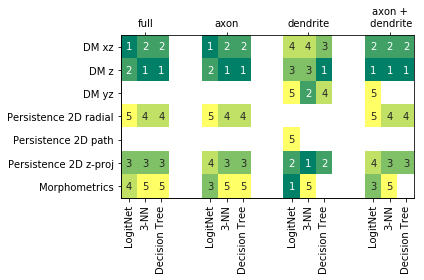

In [52]:
plt.figure(figsize=(6,4))
sns.heatmap(compare_scores, annot=True,cmap='summer', yticklabels=stat_labels, cbar=False )
sns.despine()
_ = plt.gca().set_xticks([0.5,1.5,2.5,5.5,6.5,7.5,10.5,11.5,12.5,15.5,16.5,17.5])
_ = plt.gca().set_xticklabels(['LogitNet', '3-NN', 'Decision Tree']*4, rotation=90)

ax2 = plt.gca().twiny()
ax2.set_xlim([0,18])
_ = ax2.set_xticks([1.5,6.5, 11.5, 16.5])
_ = ax2.set_xticklabels(['full', 'axon', 'dendrite', 'axon +\n dendrite'])
plt.tight_layout()

In [53]:
compare_scores = np.zeros((len(stats),14))

for ix,s in enumerate(stats):
    try:
        # fill log loss column
        compare_scores[ix,0] = rankings['log_loss_test'][1]['full'][s]
    except KeyError:
        continue

    compare_scores[ix,1] = rankings['accuracy_test'][1]['full'][s]
    compare_scores[ix,2] = rankings['f1_test'][1]['full'][s]
    compare_scores[ix,3] = rankings['mcc_test'][1]['full'][s]
    
    # get 3-NN scores
    compare_scores[ix,6] = rankings['accuracy_test'][6]['full'][s]
    compare_scores[ix,7] = rankings['f1_test'][6]['full'][s]
    compare_scores[ix,8] = rankings['mcc_test'][6]['full'][s]
    
    # get scores for decision tree
    try: 
        compare_scores[ix,11] = rankings['accuracy_test'][5]['full'][s]
    except KeyError:
        continue
    compare_scores[ix,12] = rankings['f1_test'][5]['full'][s]
    compare_scores[ix,13] = rankings['mcc_test'][5]['full'][s]

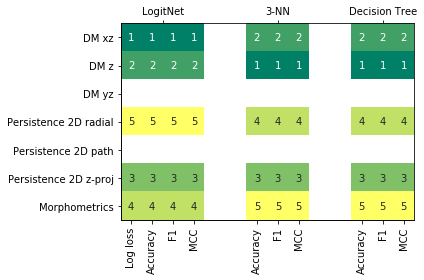

In [54]:
compare_scores[compare_scores == 0] = np.nan

stat_labels = ['DM xz', 'DM z', 'DM yz',  
               'Persistence 2D radial', 'Persistence 2D path', 'Persistence 2D z-proj',  
               'Morphometrics' ]

cmap = plt.cm.summer
cmap.set_bad((1, 1, 1, 1))

sns.heatmap(compare_scores[[0,1,2,3,4,5,6],:], annot=True,cmap='summer',yticklabels=stat_labels, cbar=False )
sns.despine()
_ = plt.gca().set_xticks([0.5,1.5,2.5,3.5, 6.5,7.5,8.5,11.5,12.5,13.5])
_ = plt.gca().set_xticklabels(['Log loss']+['Accuracy', 'F1', 'MCC']*3, rotation=90)

ax2 = plt.gca().twiny()
ax2.set_xlim([0,14])
_ = ax2.set_xticks([2,7.5, 12.5])
_ = ax2.set_xticklabels(['LogitNet', '3-NN', 'Decision Tree'])
plt.tight_layout()